<a href="https://colab.research.google.com/github/omprakashnahak/book-recommendation-system/blob/main/Bookrecommendationproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# STEP 2: LOAD DATA
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
book_tags = pd.read_csv('book_tags.csv')
tags = pd.read_csv('tags.csv')

# Optional: sample ratings data to avoid memory issues
ratings = ratings.sample(frac=0.10, random_state=42)

In [ ]:
print("Books DataFrame:")
print(f"Number of rows: {books.shape[0]}")
print(f"Number of columns: {books.shape[1]}")
print("Column names:", books.columns.tolist())
print("-" * 30)

print("Ratings DataFrame:")
print(f"Number of rows: {ratings.shape[0]}")
print(f"Number of columns: {ratings.shape[1]}")
print("Column names:", ratings.columns.tolist())
print("-" * 30)

print("Book Tags DataFrame:")
print(f"Number of rows: {book_tags.shape[0]}")
print(f"Number of columns: {book_tags.shape[1]}")
print("Column names:", book_tags.columns.tolist())
print("-" * 30)

print("Tags DataFrame:")
print(f"Number of rows: {tags.shape[0]}")
print(f"Number of columns: {tags.shape[1]}")
print("Column names:", tags.columns.tolist())
print("-" * 30)

Books DataFrame:
Number of rows: 10000
Number of columns: 23
Column names: ['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year', 'original_title', 'title', 'language_code', 'average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url', 'small_image_url']
------------------------------
Ratings DataFrame:
Number of rows: 98176
Number of columns: 3
Column names: ['book_id', 'user_id', 'rating']
------------------------------
Book Tags DataFrame:
Number of rows: 999912
Number of columns: 3
Column names: ['goodreads_book_id', 'tag_id', 'count']
------------------------------
Tags DataFrame:
Number of rows: 34252
Number of columns: 2
Column names: ['tag_id', 'tag_name']
------------------------------


In [ ]:
# STEP 3: DATA PREPROCESSING

# Merge book info with ratings
data = ratings.merge(books, on='book_id')

# Drop unnecessary columns
data = data[['user_id', 'book_id', 'title', 'authors', 'average_rating', 'rating']]

# Encode categorical features
le_user = LabelEncoder()
le_book = LabelEncoder()
data['user_id'] = le_user.fit_transform(data['user_id'])
data['book_id'] = le_book.fit_transform(data['book_id'])

# Target: classify as liked (1) or not liked (0) -> assume rating >= 4 as liked
data['liked'] = data['rating'].apply(lambda x: 1 if x >= 4 else 0)


In [ ]:
# STEP 4: TRAIN-TEST SPLIT
features = data[['user_id', 'book_id', 'average_rating']]
target = data['liked']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
# STEP 5: DEFINE MODELS
models = {
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Ridge Classifier": RidgeClassifier()
}

In [ ]:
# STEP 6: EVALUATE MODELS
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    results.append({
        "Model": name,
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    })

In [ ]:
# STEP 7: HYBRID MODEL: SVD + KNN
# SVD for dimensionality reduction
svd = TruncatedSVD(n_components=3) # Reduced n_components to 3
X_svd = svd.fit_transform(features)

# Use KNN on reduced features
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, target, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_svd, y_train_svd)
knn_preds = knn.predict(X_test_svd)

# Evaluate
precision = precision_score(y_test_svd, knn_preds)
recall = recall_score(y_test_svd, knn_preds)
f1 = f1_score(y_test_svd, knn_preds)

results.append({
    "Model": "Hybrid (SVD + KNN)",
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1 Score": round(f1, 4)
})


Confusion Matrix Visualizations:


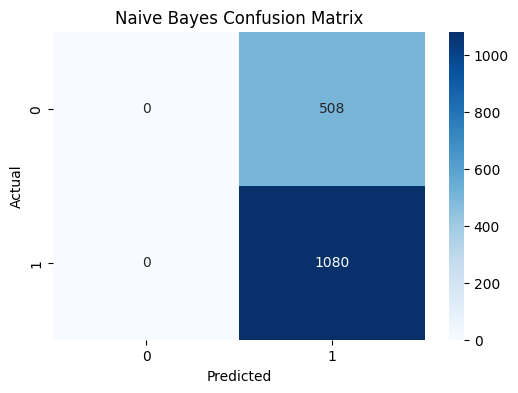

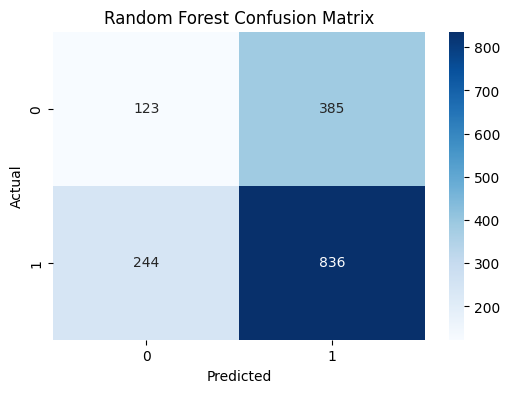

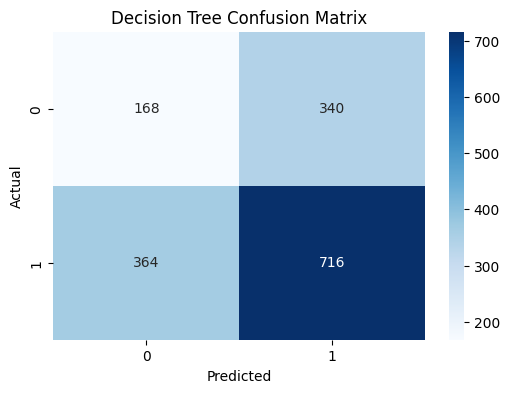

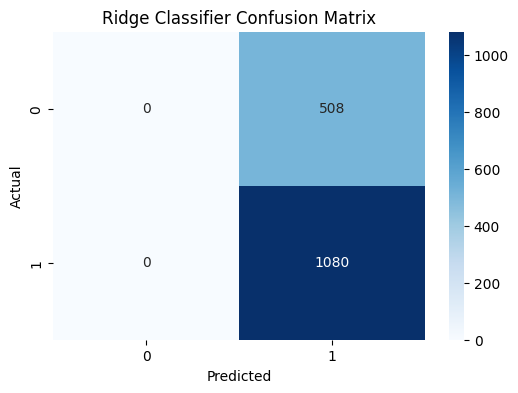

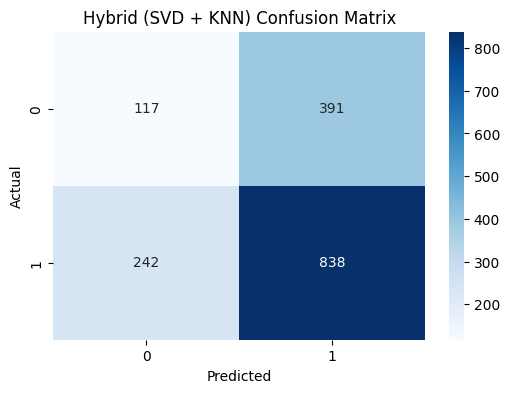

In [ ]:
# STEP 10: VISUALIZE CONFUSION MATRICES
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print("\nConfusion Matrix Visualizations:")

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    plot_confusion_matrix(cm, f'{name} Confusion Matrix')

# Confusion matrix for the Hybrid (SVD + KNN) model
plot_confusion_matrix(confusion_matrix(y_test_svd, knn_preds), 'Hybrid (SVD + KNN) Confusion Matrix')

In [ ]:
# STEP 8: DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("Performance Metrics:")
print(results_df)


Performance Metrics:
                Model  Precision  Recall  F1 Score
0         Naive Bayes     0.6801  1.0000    0.8096
1       Random Forest     0.6822  0.7750    0.7256
2       Decision Tree     0.6800  0.6630    0.6714
3    Ridge Classifier     0.6801  1.0000    0.8096
4  Hybrid (SVD + KNN)     0.6819  0.7759    0.7259


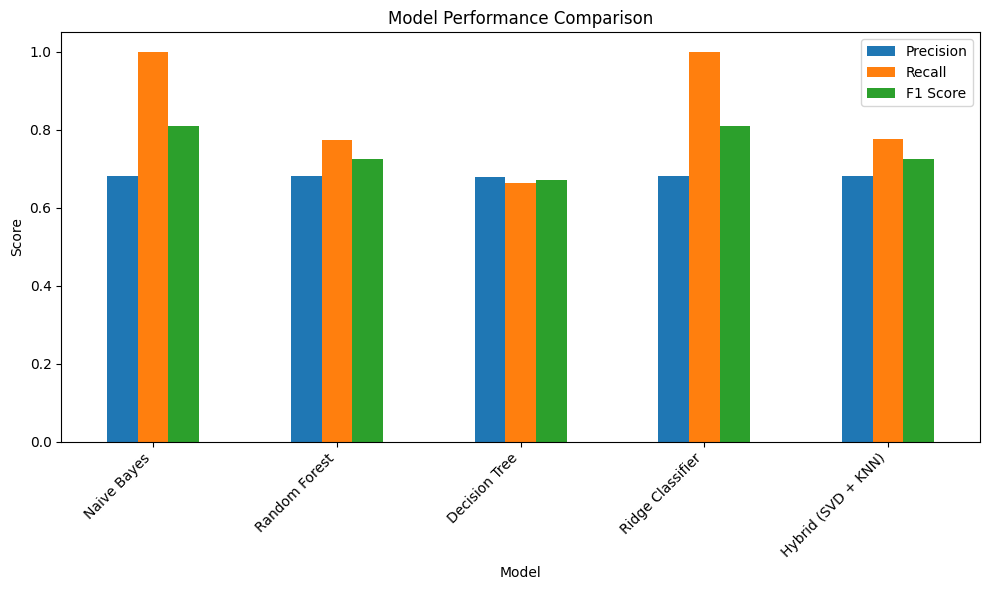

In [ ]:
# STEP 8.1: VISUALIZE PERFORMANCE METRICS
results_df.plot(x='Model', y=['Precision', 'Recall', 'F1 Score'], kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# STEP 9: TOP BOOK RECOMMENDATIONS
# For a sample user, find top books (based on average_rating)
top_books = books[['book_id', 'title', 'authors', 'average_rating']].sort_values(by='average_rating', ascending=False).head(5)
top_books


,book_id,title,authors,average_rating
3627,24812,The Complete Calvin and Hobbes,Bill Watterson,4.82
861,17332218,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,4.77
3274,8,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré",4.77
7946,5031805,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem",4.76
8853,95602,Mark of the Lion Trilogy,Francine Rivers,4.76
